In [1]:
import pandas as pd
import os
import pickle
import copy
import seaborn as sns
import matplotlib.pyplot as plt

from conf_ensemble import ConfEnsembleLibrary
from tqdm import tqdm
from rdkit.Geometry.rdGeometry import Point3D
from rdkit import Chem
from ccdc.conformer import ConformerGenerator, MoleculeMinimiser
from ccdc.molecule import Molecule
from ccdc_rdkit_connector import CcdcRdkitConnector

In [2]:
# To be able to save conformer properties
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps) 

In [3]:
data_dir_path = 'data/'

# Extract PDBBind conformations

In [4]:
pdbbind_refined_dir_path = '../PDBBind/PDBbind_v2020_refined/refined-set/'
pdbbind_general_dir_path = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'

In [5]:
widths = [6,6,7,6,17,9,200]
cols = 'PDB code, resolution, release year, -logKd/Ki, Kd/Ki, reference, ligand name'.replace(', ', ',').split(',')
pl_data = pd.read_fwf(os.path.join(pdbbind_refined_dir_path, 'index', 'INDEX_general_PL_data.2020'), widths=widths, skiprows=6, header=None)
pl_data.columns=cols

In [6]:
pl_data.head()

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,reference,ligand name
0,3zzf,2.20,2012,0.40,Ki=400mM //,3zzf.pdf,(NLG)
1,3gww,2.46,2009,0.45,IC50=355mM //,3gwu.pdf,(SFX)
2,1w8l,1.80,2004,0.49,Ki=320mM //,1w8l.pdf,(1P3)
3,3fqa,2.35,2009,0.49,IC50=320mM //,3fq7.pdf,(GAB&PMP)
4,1zsb,2.00,1996,0.60,Kd=250mM //,1zsb.pdf,(AZM)


In [7]:
pl_data = pl_data[~pl_data['ligand name'].str.contains('-mer')]

In [8]:
pl_data.shape

(16844, 7)

In [9]:
correct_pdb_ids = pl_data['PDB code'].values
#pdb_ids = sorted([dir for dir in os.listdir(pdbbind_dir) if len(dir) == 4])

In [10]:
def extract_pdbbind_mols(directory_path, query_pdb_ids) :
    mols = []
    pdb_ids = [pdb_id for pdb_id in os.listdir(directory_path) if pdb_id in query_pdb_ids]
    for pdb_id in pdb_ids :
        mol2path = os.path.join(directory_path, pdb_id, f'{pdb_id}_ligand.mol2')
        try :
            mol = Chem.rdmolfiles.MolFromMol2File(mol2path)
            if mol is not None :
                rdmol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
                if rdmol is not None : #rdkit parsable
                    #mol = PropertyMol(mol)
                    mol.GetConformer().SetProp('PDB_ID', pdb_id)
                    mols.append(mol)
                else :
                    print('Not RDKit parsable')
        except :
            print('Impossible to read mol2 file for ' + pdb_id)
            
    return mols

In [11]:
general_mols = extract_pdbbind_mols(pdbbind_general_dir_path, correct_pdb_ids)
print(len(general_mols))

RDKit WARNING: [12:52:04] 6a05_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:04] 1r0x_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:04] 6a05_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:04] 1r0x_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:04] 1w1g_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:04] 1w1g_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:04] 2k0g_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:04] 1it6_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:04] 4lph_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:04] 6oh3_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:04] 3fjz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:04] 6eo0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING

Not RDKit parsable


RDKit WARNING: [12:52:05] 2za3_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:05] 4dht_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:05] 2za3_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:05] 1ml1_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:05] 5ogk_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:05] 5knr_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:05] 1ml1_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:05] 5ogk_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:05] 5knr_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:05] 4jit_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:05] 4jit_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:05] 4li0_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:05] 4li0_ligand: warning - O.co2 with non C.2 or S.

Not RDKit parsable


RDKit WARNING: [12:52:06] 2gmk_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:06] 3wyj_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:06] 4fut_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:06] 4p4s_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:06] 5agj_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:06] 2gmk_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:06] 3wyj_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:06] 4fut_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:06] 4p4s_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:06] 5agj_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:06] 1n0t_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:06] 1n0t_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:06] 2lyb_ligand: warning - O.co2 wit

Not RDKit parsable


RDKit WARNING: [12:52:09] 5w19_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 5nz2_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 5tzd_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:09] 5w19_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 1lvk_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:09] 5nz2_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:09] 5tzd_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:09] 1lvk_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 1lor_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:09] 1lor_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 4p4b_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 1o45_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 3zjv_ligand: warn

Not RDKit parsable


RDKit WARNING: [12:52:09] 6ak6_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 2gqn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:09] 6ak6_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:09] 2gqn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 4lj3_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 6eji_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 5khi_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 3ioi_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 1o4f_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:09] 4lj3_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 2o4h_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:09] 3wc7_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:09] 6e

10635


[12:52:10] 1csi_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:10] 2p3o_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:10] 1g9r_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:10] 3v0l_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:10] 4dum_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:10] 3p23_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:10] 4bzs_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:10] 2clf_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:10] 6pk7_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:10] 3v0l_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:10] 4dum_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:10] 3p23_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:10] 4bzs_ligand: warning - O.co2 with non C.2 or S.

In [12]:
refined_mols = extract_pdbbind_mols(pdbbind_refined_dir_path, correct_pdb_ids)
print(len(refined_mols))

RDKit WARNING: [12:52:11] 1pdz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:11] 1pdz_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:11] 5cks_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:11] 2zz2_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:11] 3fzn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:11] 2e94_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:11] 4u6c_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:11] 1ado_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:11] 5cks_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:11] 2zz2_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:11] 3fzn_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:11] 2e94_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:11] 4u6c_ligand: warning - O.co2 wit

4400


[12:52:14] 3tif_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:14] 2rkd_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:14] 3k5x_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:14] 1m5w_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:14] 3n7o_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:14] 2wec_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:14] 4umb_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:14] 4w97_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:14] 2x97_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [12:52:14] 6cvf_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:14] 2rkd_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:14] 3k5x_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.
[12:52:14] 1m

In [13]:
with open(os.path.join(data_dir_path, 'pdbbind_general_mol_list.p'), 'wb') as f :
    pickle.dump(general_mols, f)

In [14]:
with open(os.path.join(data_dir_path, 'pdbbind_refined_mol_list.p'), 'wb') as f :
    pickle.dump(refined_mols, f)

In [15]:
general_CEL = ConfEnsembleLibrary(general_mols)
refined_CEL = ConfEnsembleLibrary(refined_mols)

100%|█████████████████████████████████████| 4400/4400 [00:02<00:00, 2011.61it/s]


In [16]:
pdbbind_CEL = general_CEL.merge(refined_CEL)

In [17]:
os.makedirs(os.path.join(data_dir_path, 'raw'), exist_ok=True)

In [18]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_general_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(general_CEL, f)

In [19]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_refined_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(refined_CEL, f)

In [20]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(pdbbind_CEL, f)

# Extract Platinum conformations

In [21]:
sdsupplier = Chem.rdmolfiles.SDMolSupplier(os.path.join(data_dir_path, 'platinum-dataset-2017-01-sdf', 'platinum_dataset_2017_01.sdf'))
platinum_mols = [mol for mol in sdsupplier]

In [22]:
len(platinum_mols)

4548

In [23]:
# Add PDB_ID information to conformer
with open(os.path.join(data_dir_path, 'platinum-dataset-2017-01-sdf', 'platinum_dataset_2017_01.sdf')) as f :
    lines = f.readlines()
    lines = [line.strip() for line in lines]

pdb_ids = []
new_mol = True
for line in lines :
    if new_mol :
        pdb_ids.append(line)
        new_mol = False
    if line == '$$$$' :
        new_mol = True
        
for i, mol in enumerate(tqdm(platinum_mols)) :
    mol.GetConformer().SetProp('PDB_ID', pdb_ids[i])

100%|███████████████████████████████████| 4548/4548 [00:00<00:00, 678439.90it/s]


In [24]:
platinum_CEL = ConfEnsembleLibrary(platinum_mols)

100%|█████████████████████████████████████| 4548/4548 [00:01<00:00, 2383.07it/s]


In [25]:
with open(os.path.join(data_dir_path, 'raw', 'platinum_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(platinum_CEL, f)

# Join PDBBind and Platinum, and compare the 2 datasets

In [26]:
all_CEL = pdbbind_CEL.merge(platinum_CEL)

In [27]:
all_CEL.get_num_molecules()

15928

In [28]:
all_smiles = [smiles for smiles, ce in all_CEL.get_unique_molecules()]
pdbbind_smiles = [smiles for smiles, ce in pdbbind_CEL.get_unique_molecules()]
platinum_smiles = [smiles for smiles, ce in platinum_CEL.get_unique_molecules()]

In [29]:
len(pdbbind_smiles)

12344

In [30]:
len(platinum_smiles)

4548

In [31]:
smiles_df = pd.DataFrame(all_smiles, columns=['smiles'])

In [32]:
smiles_df['pdbbind'] = smiles_df['smiles'].isin(pdbbind_smiles)
smiles_df['platinum'] = smiles_df['smiles'].isin(platinum_smiles)

In [33]:
pdbbind_n_heavy_atoms = [ce.mol.GetNumHeavyAtoms() for smiles, ce in pdbbind_CEL.get_unique_molecules()]
platinum_n_heavy_atoms = [ce.mol.GetNumHeavyAtoms() for smiles, ce in platinum_CEL.get_unique_molecules()]

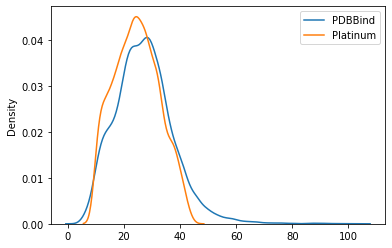

In [34]:
sns.kdeplot(pdbbind_n_heavy_atoms, label='PDBBind')
sns.kdeplot(platinum_n_heavy_atoms, label='Platinum')
plt.legend()
plt.show()

In [35]:
# For computational (conformation generation) and dataset matching reasons,
# PDBBind molecules having more than 50 heavy atoms were excluded

In [36]:
included_smiles = [smiles for smiles, ce in all_CEL.get_unique_molecules() if ce.mol.GetNumHeavyAtoms() <= 50]
smiles_df['included'] = smiles_df['smiles'].isin(included_smiles)

In [37]:
len(included_smiles)

15645

In [38]:
ccdc_rdkit_connector = CcdcRdkitConnector()

In [39]:
initial_ccdc_mols = []
corresponding_ce_mols = []
ccdc_parsed_smiles = []
for smiles, conf_ensemble in tqdm(all_CEL.get_unique_molecules()) :
    if smiles in included_smiles : # see comments above
        try :
            ccdc_mol = Molecule.from_string(smiles, format='smiles')
            ccdc_mol.remove_hydrogens()
            assert conf_ensemble.mol.GetNumAtoms() == len(ccdc_mol.atoms)
            initial_ccdc_mols.append(ccdc_mol)
            corresponding_ce_mols.append(conf_ensemble.mol)
            ccdc_parsed_smiles.append(smiles)
        except Exception as e :
            print(smiles)
            print(e)

  3%|█▏                                    | 523/15928 [00:01<00:57, 269.51it/s]

C[C@]([NH3+])(CCC[CH2]~B(O)(O)O)C(=O)[O-]
Invalid content for smiles formatted string: Syntax error: unrecognised character in SMARTS: '~'


 12%|████▎                                | 1859/15928 [00:06<00:43, 326.31it/s]

CC1=CC2=[N+]3C1=CC1=[N+]4C(=CC5=[N+]6C(=CC7=[N+](C(=C2)C(C)=C7)[Mg@@-2]346)C(C)=C5CCC(=O)[O-])C(CCC(=O)[O-])=C1C
Invalid content for smiles formatted string: Syntax error: element type not recognised in SMARTS: Mg@@


 15%|█████▌                               | 2378/15928 [00:07<00:45, 297.15it/s]

[NH3+][C@@](CCC[CH2]~B(O)(O)O)(C(=O)[O-])C1CC[NH+](Cc2ccc(Cl)c(Cl)c2)CC1
Invalid content for smiles formatted string: Syntax error: unrecognised character in SMARTS: '~'


 16%|█████▋                               | 2470/15928 [00:08<00:45, 298.18it/s]

CCCCCCCCCCCC(=O)[N+]12c3ccccn3~[Rh+2]1~n1ccccc12
Invalid content for smiles formatted string: Syntax error: unrecognised character in SMARTS: '~'


 19%|███████                              | 3028/15928 [00:10<00:42, 301.38it/s]

C[NH2+][C@](CCCCB(~[OH-])([OH2+])[OH2+])(CC[NH+]1CCCCC1)C(=O)[O-]
Invalid content for smiles formatted string: Syntax error: unrecognised character in SMARTS: '~'


 21%|███████▋                             | 3285/15928 [00:11<00:43, 291.36it/s]

[NH3+][C@](CCCCB(~[OH-])([OH2+])[OH2+])(CC[NH+]1CCCCC1)C(=O)[O-]
Invalid content for smiles formatted string: Syntax error: unrecognised character in SMARTS: '~'


 25%|█████████▍                           | 4053/15928 [00:13<00:38, 304.57it/s]

[NH3+][C@](CCCCB(O)(O)~[OH-])(CC[NH+]1CCCCC1)C(=O)[O-]
Invalid content for smiles formatted string: Syntax error: unrecognised character in SMARTS: '~'


 33%|████████████                         | 5189/15928 [00:17<00:35, 301.92it/s]

[NH3+][C@@](CCCO)(CCCCB(~[OH-])([OH2+])[OH2+])C(=O)[O-]
Invalid content for smiles formatted string: Syntax error: unrecognised character in SMARTS: '~'


 38%|██████████████▏                      | 6128/15928 [00:20<00:31, 307.44it/s]

[NH3+][C@@](CCC[CH2]~B(O)(O)O)(C(=O)[O-])C(F)F
Invalid content for smiles formatted string: Syntax error: unrecognised character in SMARTS: '~'


 41%|██████████████▉                      | 6454/15928 [00:21<00:32, 293.58it/s]

CSC1=[S+][Cu@@+5]2(Cl)[N+](=C(c3ccccn3)c3cccc[n+]32)N1
Invalid content for smiles formatted string: Syntax error: element type not recognised in SMARTS: Cu@@


 41%|███████████████▎                     | 6607/15928 [00:22<00:31, 292.88it/s]

C1CC[C@H]2[NH2+]~[Pt+]~[NH2+][C@@H]2C1
Invalid content for smiles formatted string: Syntax error: unrecognised character in SMARTS: '~'


 46%|█████████████████▏                   | 7398/15928 [00:24<00:29, 292.40it/s]

C=Cc1c(C)c2n3c1[CH]c1c(C)c(C=C)c4n1[Fe@+5]31n3c(c(C)c(CCC(=O)[O-])c3[CH]c3c(CCC(=O)[O-])c(C)c(n31)[CH]4)[CH]2
Invalid content for smiles formatted string: Syntax error: element type not recognised in SMARTS: Fe@


 54%|███████████████████▉                 | 8559/15928 [00:28<00:27, 272.04it/s]

[NH3+][C@@H](CCCCB(O)(O)~[OH-])C(=O)[O-]
Invalid content for smiles formatted string: Syntax error: unrecognised character in SMARTS: '~'


100%|████████████████████████████████████| 15928/15928 [00:51<00:00, 306.79it/s]


In [40]:
smiles_df['ccdc_parsed'] = smiles_df['smiles'].isin(ccdc_parsed_smiles)

In [41]:
smiles_df.to_csv(os.path.join(data_dir_path, 'smiles_df.csv'))

In [44]:
ccdc_conformer_generator = ConformerGenerator(nthreads=18)
ccdc_conformer_generator.settings.max_conformers = 100

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


In [ ]:
for ce_mol, conformers in initial_ccdc_mols :
    

In [45]:
for chunk_idx in tqdm(chunk_idxs) :
    
    mol_list = [mol for i, mol in enumerate(initial_ccdc_mols) if i in chunk_idx]
    ce_mols = [mol for i, mol in enumerate(corresponding_ce_mols) if i in chunk_idx]
    
    conformers = ccdc_conformer_generator.generate(mol_list)
    
    for ce_mol, conformers in zip(ce_mols, conformers) :
        try :
            generated_conf_ids = ccdc_rdkit_connector.ccdc_conformers_to_rdkit_mol(conformers, ce_mol)
        except Exception as e :
            print(e)

100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 67.37it/s]


In [57]:
chl = ccdc_conformer_generator.generate(mol_list[0])

In [65]:
chl.hits[0].molecule.atoms[0].coordinates

Coordinates(x=0.154, y=2.438, z=0.119)

In [46]:
with open(os.path.join(data_dir_path, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'wb') as f :
    pickle.dump(all_CEL, f)
    
# here we only have the molecules parsed identically by RDKit (from mol2) and CSD (from smiles)